In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import sklearn.linear_model as linear_model
import seaborn as sns
from sklearn.model_selection import KFold
from IPython.display import HTML, display
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

pd.options.display.max_rows = 1000
pd.options.display.max_columns = 80

train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')

In [2]:
# Exploring Quantitative versus Qualitative features

def quantitativeVariables(frame, id_col, target_col):
    quantitative = [f for f in frame.columns if frame.dtypes[f] != 'object']
    quantitative.remove(target_col)
    quantitative.remove(id_col)
    return quantitative

def qualitativeVariables(frame):
    qualitative = [f for f in frame.columns if frame.dtypes[f] == 'object']
    return qualitative

def quantVersusQualEDA(frame):
    quantitative = quantitativeVariables(train, "Id", "SalePrice")
    qualitative = qualitativeVariables(train)
    
    print("There are ", frame.shape[0], " data samples and ", frame.shape[1], " features including ID and SalePrice")
    print("There are ", len(quantitative), " quantitative features", "\n")
    print("Quantitative: ", quantitative, "\n")
    print("There are ", len(qualitative), " qualitative features", "\n")
    print("Qualitative: ", qualitative, "\n")
    
quantVersusQualEDA(train)

There are  1460  data samples and  81  features including ID and SalePrice
There are  36  quantitative features 

Quantitative:  ['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold'] 

There are  43  qualitative features 

Qualitative:  ['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure',

In [3]:
# Some quantitative features, like MSSubClass and MoSold, are actually qualitative features

def quantToQual(frame):
    MSSubClassVals = frame['MSSubClass'].unique()
    MSSubClassDict = {}
    for val in MSSubClassVals:
        MSSubClassDict[val] = 'SC' + str(val)
    frame = frame.replace({'MSSubClass' : MSSubClassDict, 
                       'MoSold' : {1 : 'Jan', 2 : 'Feb', 3 : 'Mar', 4 : 'Apr', 5 : 'May', 6 : 'Jun',
                                   7 : 'Jul', 8 : 'Aug', 9 : 'Sep', 10 : 'Oct', 11 : 'Nov', 12 : 'Dec'}})
    return frame

train = quantToQual(train)
quantVersusQualEDA(train)

There are  1460  data samples and  81  features including ID and SalePrice
There are  34  quantitative features 

Quantitative:  ['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'YrSold'] 

There are  45  qualitative features 

Qualitative:  ['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinT

In [4]:
# Check for duplicates

def duplicateCheck(frame):
    duplicated = frame.duplicated().sum()
    print(duplicated)
    
duplicateCheck(train)

0


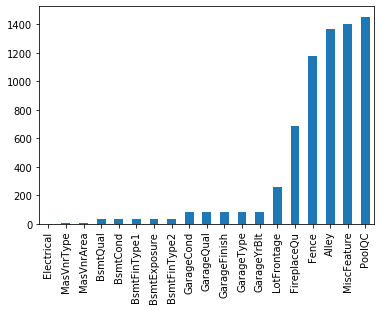

In [5]:
# Check for missing values

def missingCheck(frame):
    missing = frame.isnull().sum()
    missing = missing[missing>0]
    missing.sort_values(inplace=True)
    missing.plot.bar()
    return missing
    
missingTrain = missingCheck(train)

In [8]:
# Columns where NA is being misread as NaN

NACols = missingTrain.index.tolist()
NACols.remove('Electrical')
NACols.remove('MasVnrType')
NACols.remove('MasVnrArea')
NACols.remove('GarageYrBlt')
NACols.remove('LotFrontage')
print(NACols)

['BsmtQual', 'BsmtCond', 'BsmtFinType1', 'BsmtExposure', 'BsmtFinType2', 'GarageCond', 'GarageQual', 'GarageFinish', 'GarageType', 'FireplaceQu', 'Fence', 'Alley', 'MiscFeature', 'PoolQC']


In [9]:
# Explicitly fill these columns with NA

for col in NACols:
    train[col] = train[col].fillna('None')
    print(col, train[col].isnull().sum())

BsmtQual 0
BsmtCond 0
BsmtFinType1 0
BsmtExposure 0
BsmtFinType2 0
GarageCond 0
GarageQual 0
GarageFinish 0
GarageType 0
FireplaceQu 0
Fence 0
Alley 0
MiscFeature 0
PoolQC 0


In [10]:
def qualMostCommon(frame):
    qualitative = qualitativeVariables(frame)
    neighborhoods = frame['Neighborhood'].unique()
    qualMostCommonDict = {}
    for n in neighborhoods:
        df = frame.loc[frame['Neighborhood'] == n]
        nbhdDict = {}
        for f in qualitative:
            nbhdDict[f] = df[f].value_counts().idxmax()
        qualMostCommonDict[n] = nbhdDict    
    return qualMostCommonDict

qualMostCommonDict = qualMostCommon(train)
print(qualMostCommonDict['NAmes'])

{'MSSubClass': 'SC20', 'MSZoning': 'RL', 'Street': 'Pave', 'Alley': 'None', 'LotShape': 'Reg', 'LandContour': 'Lvl', 'Utilities': 'AllPub', 'LotConfig': 'Inside', 'LandSlope': 'Gtl', 'Neighborhood': 'NAmes', 'Condition1': 'Norm', 'Condition2': 'Norm', 'BldgType': '1Fam', 'HouseStyle': '1Story', 'RoofStyle': 'Gable', 'RoofMatl': 'CompShg', 'Exterior1st': 'MetalSd', 'Exterior2nd': 'MetalSd', 'MasVnrType': 'None', 'ExterQual': 'TA', 'ExterCond': 'TA', 'Foundation': 'CBlock', 'BsmtQual': 'TA', 'BsmtCond': 'TA', 'BsmtExposure': 'No', 'BsmtFinType1': 'BLQ', 'BsmtFinType2': 'Unf', 'Heating': 'GasA', 'HeatingQC': 'TA', 'CentralAir': 'Y', 'Electrical': 'SBrkr', 'KitchenQual': 'TA', 'Functional': 'Typ', 'FireplaceQu': 'None', 'GarageType': 'Attchd', 'GarageFinish': 'Unf', 'GarageQual': 'TA', 'GarageCond': 'TA', 'PavedDrive': 'Y', 'PoolQC': 'None', 'Fence': 'None', 'MiscFeature': 'None', 'MoSold': 'Jul', 'SaleType': 'WD', 'SaleCondition': 'Normal'}


In [11]:
def quantMedian(frame):
    quantitative = quantitativeVariables(frame,'Id','SalePrice')
    neighborhoods = frame['Neighborhood'].unique()
    quantMedianDict = {}
    for n in neighborhoods:
        df = frame.loc[frame['Neighborhood'] == n]
        nbhdDict = {}
        for f in quantitative:
            nbhdDict[f] = frame[f].median()
        quantMedianDict[n] = nbhdDict    
    return quantMedianDict

quantMedianDict = quantMedian(train)
print(quantMedianDict['NAmes'])

{'LotFrontage': 69.0, 'LotArea': 9478.5, 'OverallQual': 6.0, 'OverallCond': 5.0, 'YearBuilt': 1973.0, 'YearRemodAdd': 1994.0, 'MasVnrArea': 0.0, 'BsmtFinSF1': 383.5, 'BsmtFinSF2': 0.0, 'BsmtUnfSF': 477.5, 'TotalBsmtSF': 991.5, '1stFlrSF': 1087.0, '2ndFlrSF': 0.0, 'LowQualFinSF': 0.0, 'GrLivArea': 1464.0, 'BsmtFullBath': 0.0, 'BsmtHalfBath': 0.0, 'FullBath': 2.0, 'HalfBath': 0.0, 'BedroomAbvGr': 3.0, 'KitchenAbvGr': 1.0, 'TotRmsAbvGrd': 6.0, 'Fireplaces': 1.0, 'GarageYrBlt': 1980.0, 'GarageCars': 2.0, 'GarageArea': 480.0, 'WoodDeckSF': 0.0, 'OpenPorchSF': 25.0, 'EnclosedPorch': 0.0, '3SsnPorch': 0.0, 'ScreenPorch': 0.0, 'PoolArea': 0.0, 'MiscVal': 0.0, 'YrSold': 2008.0}


In [12]:
# Fill in missing values of GarageYrBlt with YearBuilt

train['GarageYrBlt'] = train['GarageYrBlt'].fillna(train['YearBuilt'])

In [13]:
def mostCommonNbhd(row, f, myDict):
    nbhdDict = myDict[row['Neighborhood']] 
    return nbhdDict[f] 

# Fill in Missing Qualitative Variables with the most common type for the neighborhood
for f in ['Electrical', 'MasVnrType']:
    fullSeries = train.apply(lambda row: mostCommonNbhd(row, f, qualMostCommonDict), axis=1)
    train[f] = train[f].fillna(fullSeries)
    print(f, train[f].isnull().sum())

Electrical 0
MasVnrType 0


In [14]:
# Fill in Missing Quantitative Variables with the median for the neighborhood
for f in ['MasVnrArea', 'LotFrontage']:
    fullSeries = train.apply(lambda row: mostCommonNbhd(row, f, quantMedianDict), axis=1)
    train[f] = train[f].fillna(fullSeries)
    print(f, train[f].isnull().sum())

MasVnrArea 0
LotFrontage 0


In [15]:
# No more missing data in train!

train[train.isnull().any(axis=1)]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice


In [16]:
# Order the categories of each of the qualitative features by the median of SalePrice for that category.

def encode(frame, feature):
    ordering = pd.DataFrame()
    ordering['val'] = frame[feature].unique()
    ordering.index = ordering.val
    ordering['spmedian'] = frame[[feature, 'SalePrice']].groupby(feature).median()['SalePrice']
    ordering = ordering.sort_values('spmedian')
    ordering['ordering'] = range(1,ordering.shape[0]+1)
    ordering = ordering['ordering'].to_dict()
    return(ordering)

def featureOrdering(frame):
    featureOrdering = {}
    qualitative = qualitativeVariables(frame)
    for feature in qualitative:
        ordering = encode(frame,feature)
        featureOrdering[feature] = ordering
    return featureOrdering
    
featureOrdering = featureOrdering(train)

In [17]:
# Encode qualitative variables

def qualitativeEncode(frame):
    qualitative = qualitativeVariables(frame)
    for feature in qualitative:
        frame[feature + "_E"] = frame.apply(
            lambda row: featureOrdering[feature][row[feature]], axis=1)
    return frame    

trainWithQualE = train.copy()
trainWithQualE = qualitativeEncode(trainWithQualE)
trainWithQualE.head()    

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,LandContour_E,Utilities_E,LotConfig_E,LandSlope_E,Neighborhood_E,Condition1_E,Condition2_E,BldgType_E,HouseStyle_E,RoofStyle_E,RoofMatl_E,Exterior1st_E,Exterior2nd_E,MasVnrType_E,ExterQual_E,ExterCond_E,Foundation_E,BsmtQual_E,BsmtCond_E,BsmtExposure_E,BsmtFinType1_E,BsmtFinType2_E,Heating_E,HeatingQC_E,CentralAir_E,Electrical_E,KitchenQual_E,Functional_E,FireplaceQu_E,GarageType_E,GarageFinish_E,GarageQual_E,GarageCond_E,PavedDrive_E,PoolQC_E,Fence_E,MiscFeature_E,MoSold_E,SaleType_E,SaleCondition_E
0,1,SC60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,2,2,1,1,17,4,5,4,7,2,3,12,14,3,3,5,6,4,4,2,7,5,6,5,2,5,3,7,2,6,3,5,6,3,1,5,3,9,6,5
1,2,SC20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,2,2,3,1,20,2,5,4,5,2,3,7,5,2,2,5,4,4,4,5,5,5,6,5,2,5,2,7,4,6,3,5,6,3,1,5,3,3,6,5
2,3,SC60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,2,2,1,1,17,4,5,4,7,2,3,12,14,3,3,5,6,4,4,3,7,5,6,5,2,5,3,7,4,6,3,5,6,3,1,5,3,12,6,5
3,4,SC70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,2,2,2,1,19,4,5,4,7,2,3,6,4,2,2,5,2,3,5,2,5,5,6,4,2,5,3,7,5,3,2,5,6,3,1,5,3,9,6,2
4,5,SC60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,2,2,3,1,24,4,5,4,7,2,3,12,14,3,3,5,6,4,4,4,7,5,6,5,2,5,3,7,4,6,3,5,6,3,1,5,3,11,6,5


In [18]:
# Save it to csv so you can just load in the encoded train data

trainWithQualE.to_csv('/home/seasnake/Desktop/Kaggle_Housing/trainWithQualE.csv', index=False)

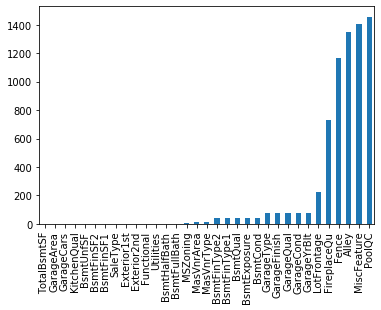

In [19]:
# Check if test set has missing features

missingTest = missingCheck(test)

In [20]:
# Find the missing features that are qualitative
MissingTestQualColumns = set(missingTest.index.to_list()) & set(qualitativeVariables(test))
print(MissingTestQualColumns)

{'BsmtFinType2', 'GarageQual', 'Alley', 'Functional', 'Exterior1st', 'FireplaceQu', 'MasVnrType', 'SaleType', 'Fence', 'MiscFeature', 'GarageCond', 'BsmtQual', 'BsmtCond', 'GarageType', 'Exterior2nd', 'MSZoning', 'BsmtExposure', 'PoolQC', 'Utilities', 'BsmtFinType1', 'GarageFinish', 'KitchenQual'}


In [21]:
# Find the cols where NA is being misread as null and explicitly fill in NA.

TestNACols = MissingTestQualColumns
TestNACols.remove('Functional')
TestNACols.remove('Utilities')
TestNACols.remove('KitchenQual')
TestNACols.remove('Exterior1st')
TestNACols.remove('Exterior2nd')
TestNACols.remove('MasVnrType')
TestNACols.remove('MSZoning')
TestNACols.remove('SaleType')
for f in TestNACols:
    test[f] = test[f].fillna('None')
    print(f, test[f].isnull().sum())

BsmtFinType2 0
GarageQual 0
Alley 0
FireplaceQu 0
Fence 0
MiscFeature 0
GarageCond 0
BsmtQual 0
BsmtCond 0
GarageType 0
BsmtExposure 0
PoolQC 0
BsmtFinType1 0
GarageFinish 0


In [22]:
# Fill in missing values of GarageYrBlt with YearBuilt as these are highly correlated

test['GarageYrBlt'] = test['GarageYrBlt'].fillna(test['YearBuilt'])

{'MSZoning', 'KitchenQual', 'Utilities', 'Exterior1st', 'Functional', 'MasVnrType', 'SaleType', 'Exterior2nd'}
{'GarageArea', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFinSF1', 'BsmtFullBath', 'MasVnrArea', 'GarageCars', 'LotFrontage', 'BsmtHalfBath'}


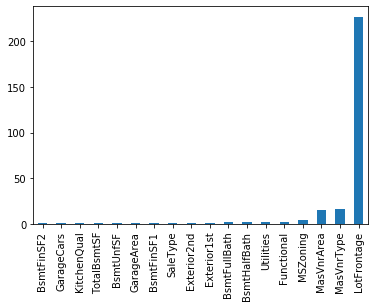

In [23]:
missingTest = missingCheck(test)
missingQualitative = set(missingTest.index.to_list()) & set(qualitativeVariables(test))
print(missingQualitative)
missingQuantitative = set(missingTest.index.to_list()) & set(quantitativeVariables(train, 'Id', 'SalePrice'))
print(missingQuantitative)

In [24]:
# Fill in the missing qualitative variables with the most common value for the neighborhood
for f in missingQualitative:
    fullSeries = test.apply(lambda row: mostCommonNbhd(row, f, qualMostCommonDict), axis=1)
    test[f] = test[f].fillna(fullSeries)
    print(f, test[f].isnull().sum())

MSZoning 0
KitchenQual 0
Utilities 0
Exterior1st 0
Functional 0
MasVnrType 0
SaleType 0
Exterior2nd 0


In [25]:
# Fill in missing quantitative variables with the median
for f in missingQuantitative:
    fullSeries = test.apply(lambda row: mostCommonNbhd(row, f, quantMedianDict), axis=1)
    test[f] = test[f].fillna(fullSeries)
    print(f, test[f].isnull().sum())

GarageArea 0
BsmtFinSF2 0
BsmtUnfSF 0
TotalBsmtSF 0
BsmtFinSF1 0
BsmtFullBath 0
MasVnrArea 0
GarageCars 0
LotFrontage 0
BsmtHalfBath 0


In [26]:
# No more missing data in test!

test[test.isnull().any(axis=1)]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition


In [27]:
# Make the same transformations to test

test = quantToQual(test)
testWithQualE = test.copy()
featureOrdering['MSSubClass']['SC150'] = 16
testWithQualE = qualitativeEncode(testWithQualE)
testWithQualE.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,LandContour_E,Utilities_E,LotConfig_E,LandSlope_E,Neighborhood_E,Condition1_E,Condition2_E,BldgType_E,HouseStyle_E,RoofStyle_E,RoofMatl_E,Exterior1st_E,Exterior2nd_E,MasVnrType_E,ExterQual_E,ExterCond_E,Foundation_E,BsmtQual_E,BsmtCond_E,BsmtExposure_E,BsmtFinType1_E,BsmtFinType2_E,Heating_E,HeatingQC_E,CentralAir_E,Electrical_E,KitchenQual_E,Functional_E,FireplaceQu_E,GarageType_E,GarageFinish_E,GarageQual_E,GarageCond_E,PavedDrive_E,PoolQC_E,Fence_E,MiscFeature_E,MoSold_E,SaleType_E,SaleCondition_E
0,1461,SC20,RH,80.0,11622,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,...,2,2,1,1,10,2,5,4,5,2,3,12,14,2,2,5,4,3,4,2,4,4,6,3,2,5,2,7,2,6,2,5,6,3,1,2,3,5,6,5
1,1462,SC20,RL,81.0,14267,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,...,2,2,2,1,10,4,5,4,5,4,3,6,3,3,2,5,4,3,4,2,5,5,6,3,2,5,3,7,2,6,2,5,6,3,1,5,4,5,6,5
2,1463,SC60,RL,74.0,13830,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,...,2,2,1,1,14,4,5,4,7,2,3,12,14,2,2,5,6,4,4,2,7,5,6,4,2,5,2,7,4,6,4,5,6,3,1,2,3,7,6,5
3,1464,SC60,RL,78.0,9978,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20.0,TA,TA,PConc,TA,TA,No,GLQ,602.0,Unf,0.0,324.0,926.0,GasA,...,2,2,1,1,14,4,5,4,7,2,3,12,14,3,2,5,6,3,4,2,7,5,6,5,2,5,3,7,5,6,4,5,6,3,1,5,3,5,6,5
4,1465,SC120,RL,43.0,5005,Pave,None,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,None,0.0,Gd,TA,PConc,Gd,TA,No,ALQ,263.0,Unf,0.0,1017.0,1280.0,GasA,...,4,2,1,1,23,4,5,5,5,2,3,9,9,2,3,5,6,4,4,2,5,5,6,5,2,5,3,7,2,6,3,5,6,3,1,5,3,2,6,5


In [28]:
# Save it to csv so you can just load in the encoded train data

testWithQualE.to_csv('/home/seasnake/Desktop/Kaggle_Housing/testWithQualE.csv', index=False)